In [1]:
import src.service.get_data as av
import src.model.SplitData as sd
import src.model.WindowGenerator as wg
import src.model.Baseline as bl
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import src.model.ComplieFit as cf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
API_KEY = "trail"
alpha_vantage = av.AlphaVantageAPI(API_KEY)
df = alpha_vantage.get_weekly_stock_prices("AAPL")

2025-03-03 06:33:54,033 - INFO - Loading data from data\AAPL_20250303.json


In [3]:
split_data = sd.SplitData(df)

In [4]:
window = wg.WindowGenerator(input_width=30, label_width=5, shift=6, split_data=split_data, label_columns=['close'])
window

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [31 32 33 34 35]
Label column name(s): ['close']

In [5]:
# Stack three slices, the length of the total window.
example_window = tf.stack([
            np.array(split_data.train_df[:window.total_window_size]),
            np.array(split_data.train_df[100:100+window.total_window_size]),
            np.array(split_data.train_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 36, 7)
Inputs shape: (3, 30, 7)
Labels shape: (3, 5, 1)


In [6]:
#window.example = example_inputs, example_labels

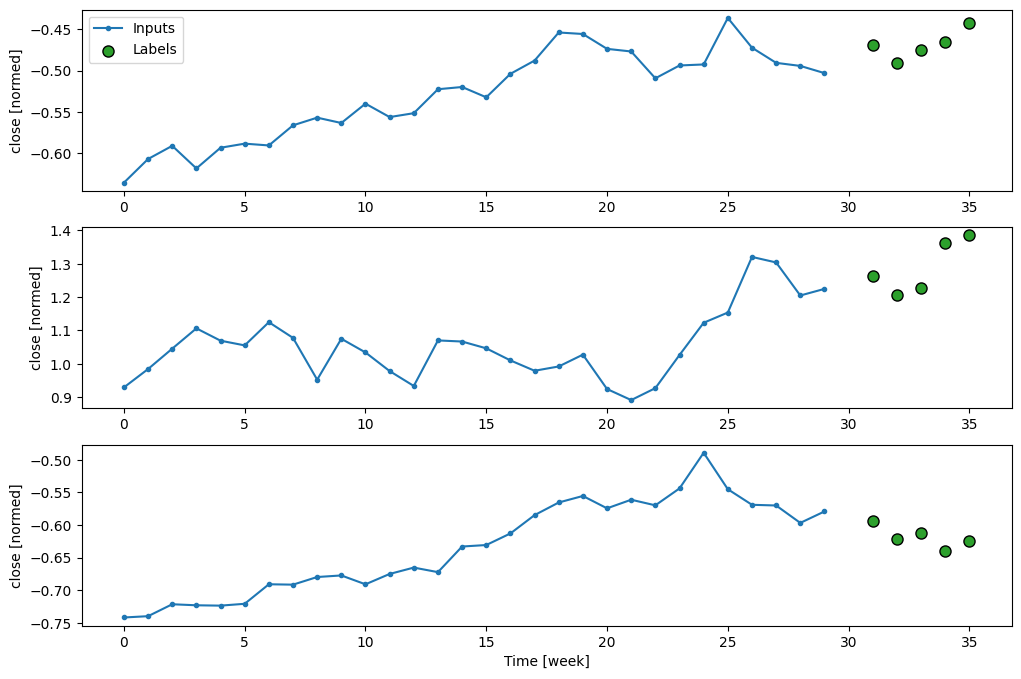

In [7]:
window.plot()

In [8]:
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 7)
Labels shape (batch, time, features): (32, 5, 1)


2025-03-03 06:33:55.811763: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
single_step_window = wg.WindowGenerator(
    input_width=1, label_width=1, shift=1,split_data=split_data,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [10]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


2025-03-03 06:33:55.945849: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
"""class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]"""

'class Baseline(tf.keras.Model):\n  def __init__(self, label_index=None):\n    super().__init__()\n    self.label_index = label_index\n\n  def call(self, inputs):\n    if self.label_index is None:\n      return inputs\n    result = inputs[:, :, self.label_index]\n    return result[:, :, tf.newaxis]'

In [12]:
baseline = bl.Baseline(label_index=single_step_window.column_indices['close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0391  


In [13]:
wide_window = wg.WindowGenerator(
    input_width=24, label_width=24, shift=1, split_data = split_data,
    label_columns=['close'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

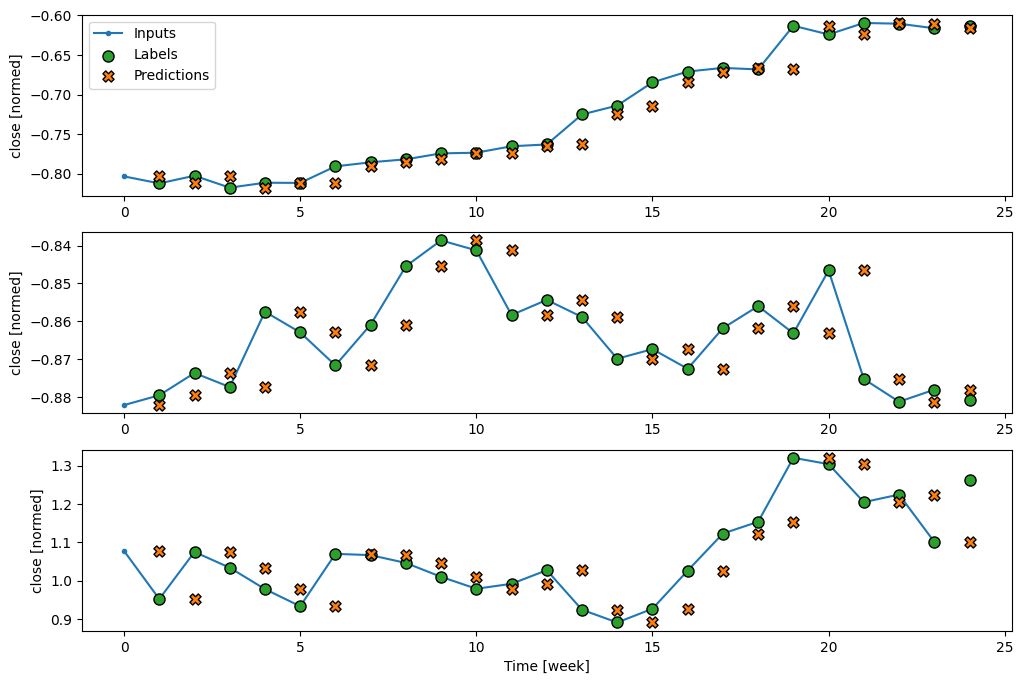

In [14]:
wide_window.plot(baseline)

In [15]:
linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
    ])
history = cf.compile_and_fit(linear, single_step_window)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4604 - mean_absolute_error: 0.5233 - val_loss: 1.9614 - val_mean_absolute_error: 1.0782
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3914 - mean_absolute_error: 0.4404 - val_loss: 2.0400 - val_mean_absolute_error: 1.1319
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2975 - mean_absolute_error: 0.3665 - val_loss: 2.0005 - val_mean_absolute_error: 1.1445


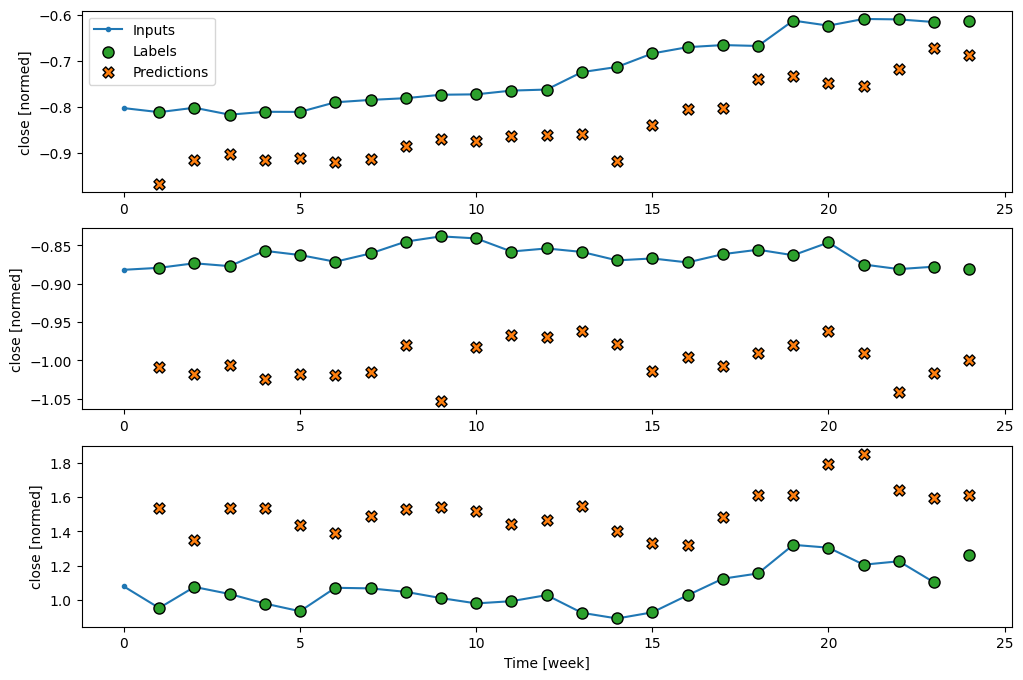

In [16]:
wide_window.plot(linear)

In [17]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = cf.compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1479 - mean_absolute_error: 0.5679 - val_loss: 0.0639 - val_mean_absolute_error: 0.1737
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0483 - mean_absolute_error: 0.0906 - val_loss: 0.1792 - val_mean_absolute_error: 0.3316
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - mean_absolute_error: 0.0563 - val_loss: 0.0857 - val_mean_absolute_error: 0.2160
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0891 - mean_absolute_error: 0.2175 


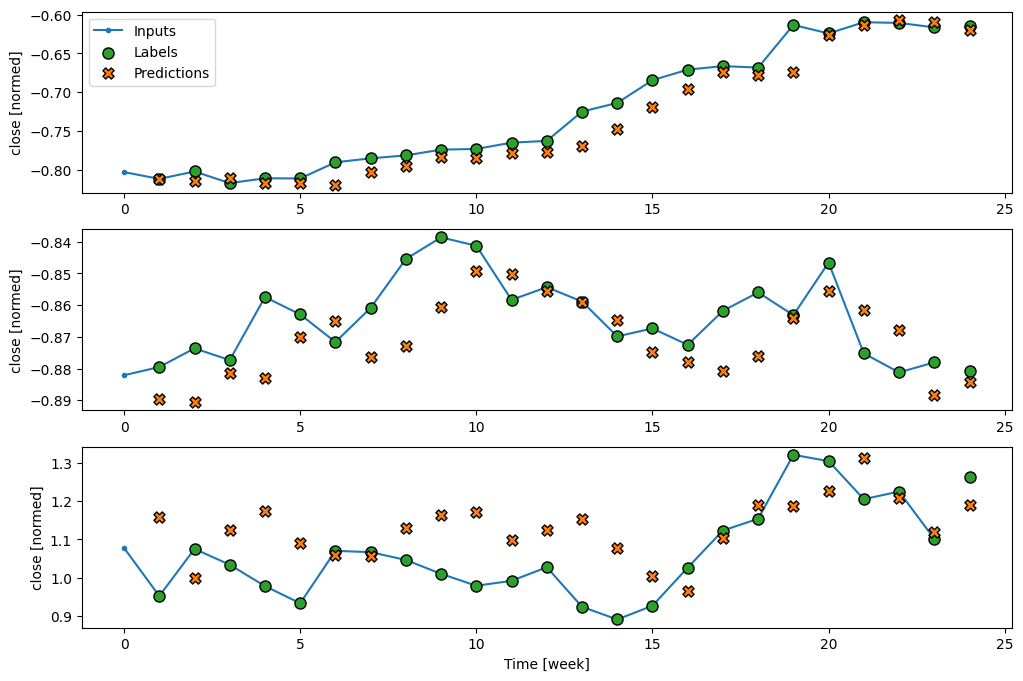

In [18]:
wide_window.plot(dense)

In [19]:
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)
val_performance['Dense']

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0848 - mean_absolute_error: 0.2194 


{'loss': 0.08574072271585464, 'mean_absolute_error': 0.2160080373287201}